In [11]:
import os
import numpy as np
import torch
from PIL import Image
from torch import nn
from torch.nn import BatchNorm2d, CrossEntropyLoss
from torch.nn.functional import relu
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, random_split
from torch import onnx
from torchvision import transforms
%pip install torchmetrics
from torchmetrics.functional import accuracy, precision, recall, f1_score
from torchmetrics.functional.segmentation import mean_iou
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import List, Type

Note: you may need to restart the kernel to use updated packages.


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data loading

In [13]:
img = []
mask = []
img_path = "/kaggle/input/slumdata/updated_complete_data/train_img"
mask_path = "/kaggle/input/slumdata/updated_complete_data/train_mask"
for img_name in sorted(os.listdir(img_path)):
    cur_img = Image.open(os.path.join(img_path, img_name))
    cur_img = cur_img.resize((128, 128))
    img.append(cur_img)

for mask_name in sorted(os.listdir(mask_path)):
    cur_mask = Image.open(os.path.join(mask_path, mask_name))
    cur_mask = cur_mask.resize((128, 128))
    mask.append(cur_mask)

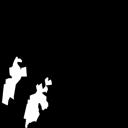

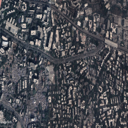

In [14]:
display(mask[15])
display(img[15])

In [15]:
img_train, img_val, mask_train, mask_val = train_test_split(
    img,
    mask,
    shuffle=True,
    random_state=42,
    train_size=0.8,
)

In [16]:
print(len(img_train))
print(len(img_val))
print(len(mask_train))
print(len(mask_val))

2270
568
2270
568


In [17]:
test_img = []
test_mask = []
test_img_path = "/kaggle/input/slumdata/updated_complete_data/val_img"
test_mask_path = "/kaggle/input/slumdata/updated_complete_data/val_mask"
for img_name in sorted(os.listdir(test_img_path)):
    cur_img = Image.open(os.path.join(test_img_path, img_name))
    cur_img = cur_img.resize((128, 128))
    test_img.append(cur_img)

for mask_name in sorted(os.listdir(test_mask_path)):
    cur_mask = Image.open(os.path.join(test_mask_path, mask_name))
    cur_mask = cur_mask.resize((128,128))
    test_mask.append(cur_mask)

## Hyperparamters

In [18]:
shuffle = True
batch_size = 32
num_workers = 2
epoch = 20
learning_rate = 0.0005

In [19]:
class CustomDataset(Dataset):
    def __init__(self, img, mask):
        self.img = img
        self.mask = mask

    def __getitem__(self, index):
        return (self.img[index], self.mask[index])

    def __len__(self):
        return len(self.img)

In [20]:
def custom_collate(input):
    """Takes list of tuples as input and after processing them retuns the tuple of 2 tensor representing img and mask list."""
    img_list = []
    mask_list = []
    for img, mask in input:
        img = transforms.ToTensor()(img)
        img_list.append(img)
        mask = (transforms.ToTensor()(mask)//0.9).to(torch.int64)
        mask_list.append(mask)
    return (torch.stack(img_list, dim=0), torch.stack(mask_list, dim=0))

In [21]:
train_dataset = CustomDataset(img_train, mask_train)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
    collate_fn=custom_collate,
)

In [22]:
val_dataset = CustomDataset(img_val, mask_val)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=False,
    num_workers=0,
    collate_fn=custom_collate,
)

# UNet model from scrach

In [23]:
def crop_and_cat(enc_img: torch.tensor, dec_img: torch.tensor):
    """
    *Padding the encoder part is not completed yet through for current model we don't even need it.

    Depending upon the input dimensions(N*C*H*W), it either crop or pad the image coming from the encoder to match the decoder side tensor dimensions(N*C*H*W).
    Then concatenates both the tensors.
    """
    enc_shape = enc_img.shape
    dec_shape = dec_img.shape

    if enc_shape[2] >= dec_shape[2]:
        crop = (enc_shape[2] - dec_shape[2]) // 2
        enc_img = enc_img[:, :, crop : enc_shape[2] - crop, :]
    else:
        pass  # Later

    if enc_shape[3] >= dec_shape[3]:
        crop = (enc_shape[3] - dec_shape[3]) // 2
        enc_img = enc_img[:, :, :, crop : enc_shape[3] - crop]
    else:
        pass  # Later
    return torch.cat((enc_img, dec_img), dim=1)

In [24]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding="same",
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding="same",
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, input):
        return self.block(input)

In [25]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding="same",
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding="same",
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, input):
        return self.block(input)

In [26]:
class UpBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block1 = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=2,
            stride=2,
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding="same",
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                padding="same",
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, enc_img, dec_img):
        block1 = crop_and_cat(enc_img, self.block1(dec_img))
        block2 = self.block2(block1)
        return block2

In [32]:
class UNetFromScrach(nn.Module):
    """
    UNet based model build from scrach.

    This model takes the RGB image with dimensions(N*C*H*W) as input and returns the output with dimensions(N*2*H*W)
    """

    def __init__(self) -> None:
        super().__init__()
        self.block1 = DownBlock(in_channels=3, out_channels=16)
        self.block2 = DownBlock(in_channels=16, out_channels=32)
        self.block3 = DownBlock(in_channels=32, out_channels=64)

        self.block4 = Bottleneck(in_channels=64, out_channels=128)

        self.block5 = UpBlock(in_channels=128, out_channels=64)
        self.block6 = UpBlock(in_channels=64, out_channels=32)
        self.block7 = UpBlock(in_channels=32, out_channels=16)
        self.output = nn.Conv2d(
            in_channels=16, out_channels=2, kernel_size=1, padding="same"
        )

    def forward(self, input) -> torch.tensor:
        block1 = self.block1(input)#128
        block2 = self.block2(F.max_pool2d(block1,stride=2,kernel_size=2))#64
        block3 = self.block3(F.max_pool2d(block2,stride=2,kernel_size=2))#32
        
        block4 = self.block4(F.max_pool2d(block3,stride=2,kernel_size=2))#16

        block5 = self.block5(block3, block4)#32
        block6 = self.block6(block2, block5)#64
        block7 = self.block7(block1, block6)#128

        output = self.output(block7)
        return output

# Evaluation class

In [33]:
class Evalution:
    """
    To be updated..
    """

    def __init__(self) -> None:
        self.acc_list = []
        self.prec_list = []
        self.recall_list = []
        self.f1_score_list = []
        self.iou_list = []

        self.acc = -1
        self.prec = -1
        self.recall = -1
        self.f1_score = -1
        self.iou = -1
        

    def update_list(self) -> None:
        self.acc_list.append(self.acc)
        self.prec_list.append(self.prec)
        self.recall_list.append(self.recall)
        self.f1_score_list.append(self.f1_score)
        self.iou_list.append(self.iou)

        
    def show(self) -> None:
        print(
            f"Accuracy: {self.acc:.5f}, Macro-Precision: {self.prec:.5f}, Macro-Recall: {self.recall:.5f}, Macro-F1_Score: {self.f1_score:.5f}, IOU: {self.iou:.5f}"
        )

        
    def __call__(self, ypred: torch.tensor, ytrue: torch.tensor,display_result=True) -> None:
        ypred = torch.stack([torch.argmax(ypred, dim=1)],dim=1).cpu()
        ytrue=ytrue.cpu()
        self.acc = accuracy(ypred, ytrue, task="multiclass", num_classes=2).item()
        self.prec = precision(
            ypred, ytrue, task="multiclass", num_classes=2, average="macro"
        ).item()
        self.recall = recall(
            ypred, ytrue, task="multiclass", num_classes=2, average="macro"
        ).item()
        self.f1_score = f1_score(
            ypred, ytrue, task="multiclass", num_classes=2, average="macro"
        ).item()
        self.iou = mean_iou(ypred, ytrue, num_classes=2).mean()

        self.update_list()
        if display_result==True:
            self.show()

            
    def avg_and_update(self, batch_eval,display_result=True) -> None:
        self.acc = torch.tensor(batch_eval.acc).mean()
        self.prec = torch.tensor(batch_eval.prec).mean()
        self.recall = torch.tensor(batch_eval.recall).mean()
        self.f1_score = torch.tensor(batch_eval.f1_score).mean()
        self.iou = (batch_eval.iou).mean()

        self.update_list()
        if display_result==True:
            self.show()

# Training

In [34]:
model = UNetFromScrach()
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(
    model.parameters(),
    lr=learning_rate,
)

In [35]:
class Trainer:
    """
    To be updated...
    """

    def __init__(
        self,
        model,
    ) -> None:
        self.train_eval = Evalution()
        self.val_eval = Evalution()
        self.model = model

        
    def fit(
        self,
        criterion,
        optimizer,
        train_dataloader: Type[DataLoader],
        epoch: int,
        **kwargs,
    ) -> None:
        self.model = self.model.to(device)
        for cur_epoch in range(1, epoch + 1):
            batch_eval = Evalution()
            loss_list = []
            self.model.train()
            for batch_img, batch_mask_true in train_dataloader:
                batch_img = batch_img.to(device)
                batch_mask_true = batch_mask_true.to(device)
                batch_mask_pred = self.model(batch_img)
                batch_eval(ypred=batch_mask_pred, ytrue=batch_mask_true,display_result=False)
                bm_shape=batch_mask_true.shape
                loss = criterion(input=batch_mask_pred, target=batch_mask_true.view((bm_shape[0],bm_shape[2],bm_shape[3])))
                loss_list.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            print(
                f"\nEpoch [{cur_epoch}/{epoch}], Loss: {torch.tensor(loss_list).mean():.5f}"
            )
            with torch.no_grad():
                model.eval()
                print("Train metrics:")
                self.train_eval.avg_and_update(batch_eval)
                if "val_dataloader" in kwargs:
                    val_img, val_mask_true = next(iter(val_dataloader))
                    val_img=val_img.to(device)
                    val_mask_true=val_mask_true.to(device)
                    val_mask_pred = model(val_img)
                    print(f"Valiadation metrics:")
                    self.val_eval(val_mask_pred, val_mask_true)

In [37]:
trainer = Trainer(model)
trainer.fit(
    criterion=criterion,
    optimizer=optimizer,
    epoch=epoch,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
)


Epoch [1/20], Loss: 0.34899
Train metrics:
Accuracy: 0.84934, Macro-Precision: 0.82565, Macro-Recall: 0.82785, Macro-F1_Score: 0.82673, IOU: 0.55533
Valiadation metrics:
Accuracy: 0.85452, Macro-Precision: 0.82108, Macro-Recall: 0.78895, Macro-F1_Score: 0.80261, IOU: 0.48151

Epoch [2/20], Loss: 0.33656
Train metrics:
Accuracy: 0.86553, Macro-Precision: 0.81118, Macro-Recall: 0.84978, Macro-F1_Score: 0.82690, IOU: 0.54022
Valiadation metrics:
Accuracy: 0.86041, Macro-Precision: 0.83314, Macro-Recall: 0.79083, Macro-F1_Score: 0.80808, IOU: 0.47347

Epoch [3/20], Loss: 0.32789
Train metrics:
Accuracy: 0.86268, Macro-Precision: 0.82467, Macro-Recall: 0.83497, Macro-F1_Score: 0.82953, IOU: 0.52058
Valiadation metrics:
Accuracy: 0.82386, Macro-Precision: 0.77745, Macro-Recall: 0.82567, Macro-F1_Score: 0.79257, IOU: 0.49878

Epoch [4/20], Loss: 0.31827
Train metrics:
Accuracy: 0.83444, Macro-Precision: 0.80888, Macro-Recall: 0.78594, Macro-F1_Score: 0.79571, IOU: 0.47358
Valiadation metrics

# Training and Validation Plots

Text(0.5, 1.0, 'Metrics vs Epoch')

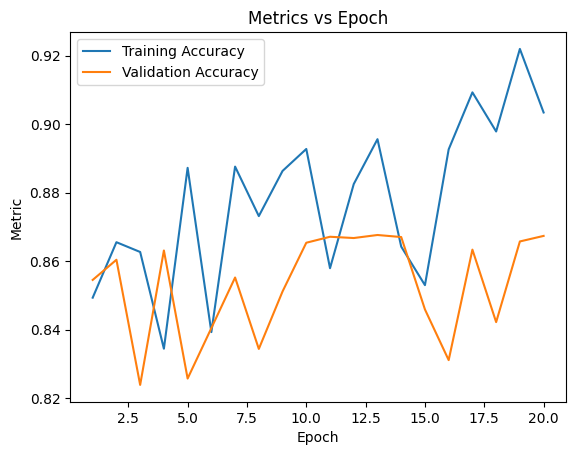

In [38]:
plt.plot(
    range(1, epoch + 1), trainer.train_eval.acc_list, label="Training Accuracy"
)
plt.plot(
    range(1, epoch + 1), trainer.val_eval.acc_list, label="Validation Accuracy"
)
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Metrics vs Epoch")

Text(0.5, 1.0, 'Metrics vs Epoch')

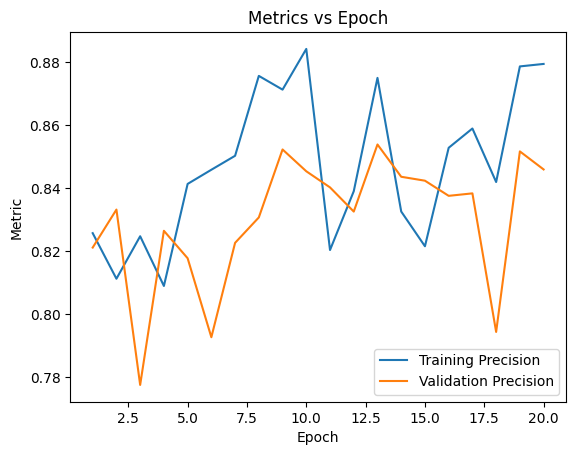

In [39]:
plt.plot(range(1, epoch + 1), trainer.train_eval.prec_list, label="Training Precision")
plt.plot(range(1, epoch + 1), trainer.val_eval.prec_list, label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Metrics vs Epoch")

Text(0.5, 1.0, 'Metrics vs Epoch')

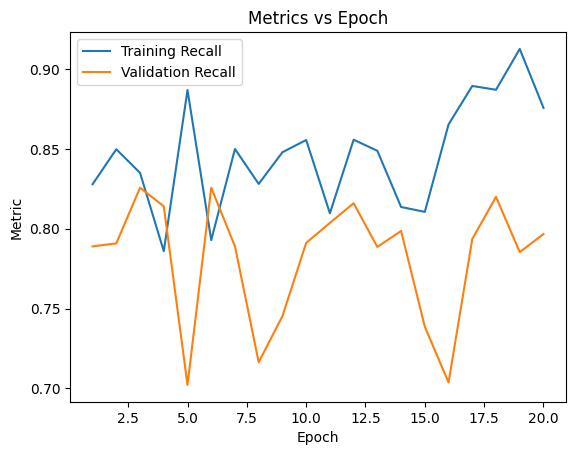

In [40]:
plt.plot(range(1, epoch + 1), trainer.train_eval.recall_list, label="Training Recall")
plt.plot(range(1, epoch + 1), trainer.val_eval.recall_list, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Metrics vs Epoch")

Text(0.5, 1.0, 'Metrics vs Epoch')

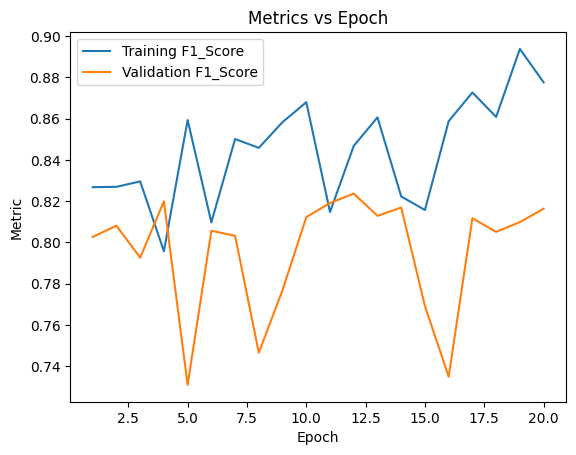

In [41]:
plt.plot(
    range(1, epoch + 1), trainer.train_eval.f1_score_list, label="Training F1_Score"
)
plt.plot(
    range(1, epoch + 1), trainer.val_eval.f1_score_list, label="Validation F1_Score"
)
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Metrics vs Epoch")

Text(0.5, 1.0, 'Metrics vs Epoch')

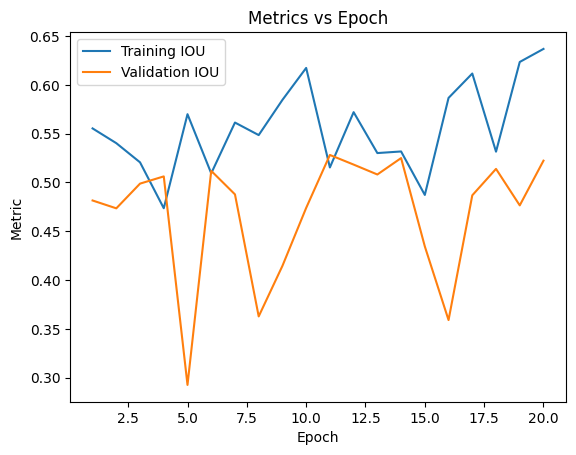

In [42]:
plt.plot(range(1, epoch + 1), trainer.train_eval.iou_list, label="Training IOU")
plt.plot(range(1, epoch + 1), trainer.val_eval.iou_list, label="Validation IOU")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Metrics vs Epoch")

# Final evaluation on test dataset

In [43]:
test_dataset = CustomDataset(test_img, test_mask)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,
    num_workers=0,
    collate_fn=custom_collate,
)

In [44]:
final_eval_img, final_eval_mask_true = next(iter(test_dataloader))
torch.onnx.export(
    model.cpu(),
    final_eval_img,
    "final_model.onnx",
    export_params=True,
    opset_version=10,
    do_constant_folding=False,
    input_names=["input"],
    output_names=["output"],
)

/tmp/ipykernel_34/27822932.py:11: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if enc_shape[2] >= dec_shape[2]:
/tmp/ipykernel_34/27822932.py:17: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if enc_shape[3] >= dec_shape[3]:


In [45]:
with torch.no_grad():
    model.eval()
    final_eval_img, final_eval_mask_true = next(iter(test_dataloader))
    final_eval_mask_pred = model(final_eval_img)
    print("Final Evaluation on test dataset:")
    final_eval = Evalution()(final_eval_mask_pred, final_eval_mask_true)

Final Evaluation on test dataset:
Accuracy: 0.92745, Macro-Precision: 0.87470, Macro-Recall: 0.90531, Macro-F1_Score: 0.88877, IOU: 0.62107


In [ ]:
! mkdir true_and_pred_masks

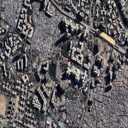

#### Original image

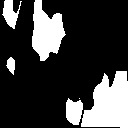

#### True mask

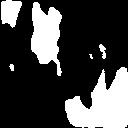

#### Predicted mask

In [51]:
from IPython.display import display, Markdown
display(transforms.ToPILImage()(final_eval_img[1]))
display(Markdown("#### Original image"))

display(transforms.ToPILImage()(final_eval_mask_true[1].to(torch.uint8)*255))
display(Markdown("#### True mask"))

display(transforms.ToPILImage()(final_eval_mask_pred[1].argmax(dim=0).to(torch.uint8)*255))
display(Markdown("#### Predicted mask"))


In [ ]:
size=len(final_eval_mask_true)
for i in range(size):
    ! mkdir "true_and_pred_masks/$i"
    
    original=transforms.ToPILImage()(final_eval_img[i])
    original.save(f'true_and_pred_masks/{i}/original_img.png')
    
    predict_mask=transforms.ToPILImage()(final_eval_mask_pred[i].argmax(dim=0).to(torch.uint8)*255)
    predict_mask.save(f'true_and_pred_masks/{i}/predicted_mask.png')
    
    true_mask=transforms.ToPILImage()(final_eval_mask_true[i].to(torch.uint8)*255)
    true_mask.save(f'true_and_pred_masks/{i}/true_mask.png')

In [193]:
! tar -zcvf true_and_pred_masks.tgz true_and_pred_masks

true_and_pred_masks/
true_and_pred_masks/211/
true_and_pred_masks/211/true_mask.png
true_and_pred_masks/211/original_img.png
true_and_pred_masks/211/predicted_mask.png
true_and_pred_masks/127/
true_and_pred_masks/127/true_mask.png
true_and_pred_masks/127/original_img.png
true_and_pred_masks/127/predicted_mask.png
true_and_pred_masks/664/
true_and_pred_masks/664/true_mask.png
true_and_pred_masks/664/original_img.png
true_and_pred_masks/664/predicted_mask.png
true_and_pred_masks/122/
true_and_pred_masks/122/true_mask.png
true_and_pred_masks/122/original_img.png
true_and_pred_masks/122/predicted_mask.png
true_and_pred_masks/685/
true_and_pred_masks/685/true_mask.png
true_and_pred_masks/685/original_img.png
true_and_pred_masks/685/predicted_mask.png
true_and_pred_masks/340/
true_and_pred_masks/340/true_mask.png
true_and_pred_masks/340/original_img.png
true_and_pred_masks/340/predicted_mask.png
true_and_pred_masks/352/
true_and_pred_masks/352/true_mask.png
true_and_pred_masks/352/original_i